<a href="https://colab.research.google.com/github/chaos44/food_recognition/blob/master/food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)#2. Get the file
d10 = drive.CreateFile({'id':'1jqXr5d-UAhOUaPIb-g7p_8xEW9XxHjUr'}) # replace the id with id of file you want to access
d20 = drive.CreateFile({'id':'1hbZ19igWGti65MXOeGOwuzbSzVAOLdlH'})
d30 = drive.CreateFile({'id':'12uU6ocY9r6BfBk8fo4BQC8BVXjDDhCBb'})
d40 = drive.CreateFile({'id':'1Hs5OVtYD8xDvLd7y6drDHUu4ErXjBvr_'})
d50 = drive.CreateFile({'id':'19FaeD7fdFlqu0U8K2DIJevtp1tb4PbBe'})
d10.GetContentFile('d10.zip')
d20.GetContentFile('d20.zip')
d30.GetContentFile('d30.zip')
d40.GetContentFile('d40.zip')
d50.GetContentFile('d50.zip')

In [ ]:
!unzip d10.zip -d food
!unzip d20.zip -d food
!unzip d30.zip -d food
!unzip d40.zip -d food
!unzip d50.zip -d food

In [1]:
from PIL import Image
import os, glob
import numpy as np
from sklearn import model_selection
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# 中心から任意のサイズをトリミング
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [3]:
# パラメータの初期化
classes = ['beefdon', 'curry', 'fish', 'humberger', 'katsudon', 'ramen', 'seafooddon', 'soba', 'spaghetti', 'tempuradon'
         , 'udon', 'lasagna', 'hamburger_steak', 'nikujaga', 'fried_rice', 'omelette', 'sukiyaki', 'sushi', 'gyoza', 'fried_chicken'
         , 'okonomiyaki', 'croquette', 'pancake', 'french_toast', 'tart', 'taco_rice', 'doria', 'takoyaki', 'tapioca', 'yakisoba'
         , 'ginger_pork', 'steak', 'roast_meat', 'bread', 'yakitori', 'rice_ball', 'goya_chanpuru', 'instant_noodle', 'meat_bun', 'gratin'
         , 'mabo_tofu', 'tiramisu', 'cream_puff', 'eclair', 'hot_dog', 'potato_salad', 'stew', 'pizza', 'french_fry', 'avocado_salad']
num_classes = len(classes)
image_size = 150

In [9]:
# 画像の読み込みとnumpy配列への変換
X_train = [] # リスト
X_test = [] # リスト
y_train = [] # リスト
y_test = [] # リスト

In [10]:
# アスペクト比を固定して、幅が指定した値になるようリサイズする。
def scale_to_width(img, width):
    height = round(img.height * width / img.width)
    return img.resize((width, height))

In [11]:
for index, classlabel in enumerate(classes):
    photos_dir = './food/' + classlabel  
    files = glob.glob(photos_dir + '/*.jpg')
    count = len(files)
    # print(classlabel, count)  
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert('RGB')
        # image = image.convert('RGB')の前にトリミングするとメモリオーバー、理由不明
        # 食材ごとにテストとトレーニングに分ける
        # 画像サイズの取得
        # 長い方に沿ってトリミング
        # image = crop_center(image, 400, 400) # resizeする時にアスペクト比を固定させるため、400*400の部分をトリミング(800 * 800より正解率が上がる)
        w, h = image.size
        image = crop_center(image, w, w) if w >= h else crop_center(image, h, h)
        image = image.resize((image_size, image_size))
        data = np.asarray(image, dtype=np.float32) / 255.0  # 正規化 # dtype=np.float32でサイズ縮小、MemoryError解消のため # 2020/7/7
        if (i < 3/4 * count):
            X_train.append(data)
            y_train.append(index)
        else: 
            X_test.append(data)
            y_test.append(index)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [12]:
print(X_train.nbytes)
print(X_test.nbytes)
print(y_train.nbytes)
print(y_test.nbytes)

3431160000
1136700000
101664
33680


In [ ]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y)
# X_train, X_test = model_selection.train_test_split(X)
# print(X_train.nbytes)
# print(X_test.nbytes)

3425760000
1142100000


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [15]:
# compute quantities requiredXXfor featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [16]:
#　モデルの定義
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# opt = SGD(lr=0.01)
opt = Adam()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.fit(X_train, y_train, batch_size=32, epochs=100)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=100)

score = model.evaluate(X_test, y_test, batch_size=32)

print(score)
# model.save('./food_recognition_cnn_50.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
398/397 [==============================] - 70s 175ms/step - loss: 3.8421 - accuracy: 0.0582
Epoch 2/100
398/397 [==============================] - 71s 178ms/step - loss: 3.7316 - accuracy: 0.0703
Epoch 3/100
398/397 [==============================] - 70s 177ms/step - loss: 3.6476 - accuracy: 0.0805
Epoch 4/100
398/397 [==============================] - 71s 177ms/step - loss: 3.5538 - accuracy: 0.0999
Epoch 5/100
398/397 [==============================] - 70s 176ms/step - loss: 3.4489 - accuracy: 0.1143
Epoch 6/100
398/397 [==============================] - 70s 176ms/step - loss: 3.3741 - accuracy: 0.1364
Epoch 7/100
398/397 [==============================] - 70s 176ms/step - loss: 3.2905 - accuracy: 0.1499
Epoch 8/100
398/397 [==============================] - 70s 176ms/step - loss: 3.2331 - accuracy: 0.1619
Epoch 9/100
398/397 [==============================] - 70s 176ms/step - loss: 3.1351 - accur

KeyboardInterrupt: ignored

In [17]:
score = model.evaluate(X_test, y_test, batch_size=32)

print(score)

132/132 [==============================] - 2s 16ms/step - loss: 2.0573 - accuracy: 0.4542
[2.0572991371154785, 0.454156756401062]


In [ ]:
model.save('./food_recognition_cnn_50.h5')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def process(data):
    plt.figure()
    plt.imshow(data)

(4230, 150, 150, 3)
fish 99

lasagna 81

fish 63

gratin 43

rice_ball 93

takoyaki 96

gratin 80

tempuradon 57

french_fry 99

soba 36

tiramisu 99

hamburger_steak 56



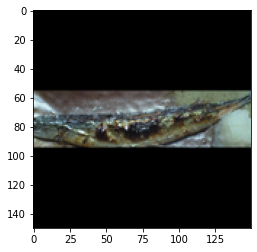

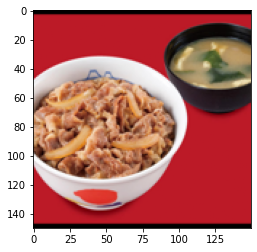

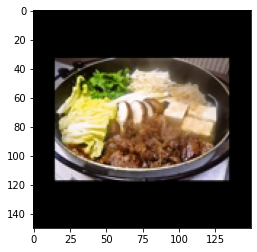

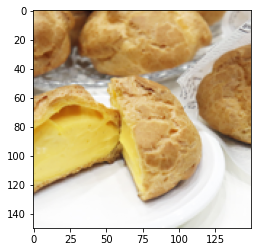

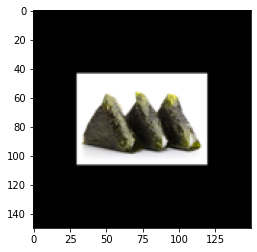

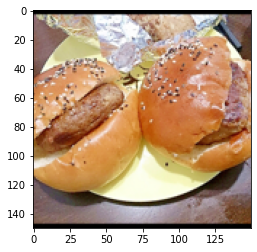

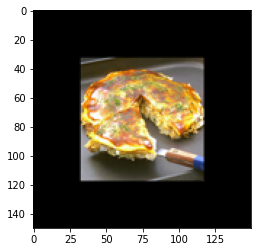

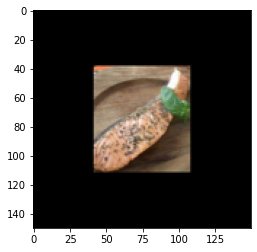

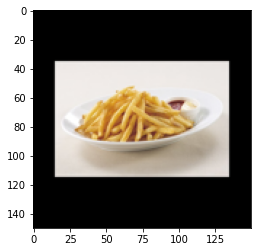

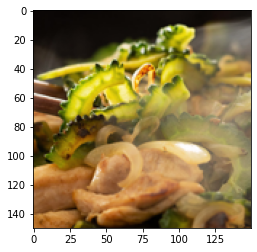

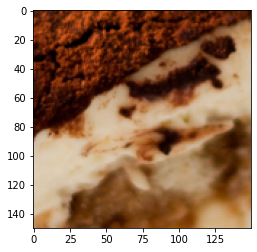

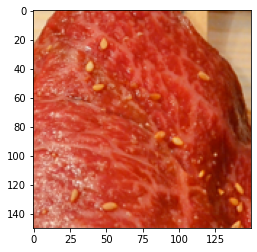

In [ ]:
print(X_test.shape)

for index, data in enumerate(X_test):
    process(data)
    X = []
    # 最後尾に追加する
    X.append(data)
    X = np.array(X)
    result = model.predict([X])[0]
    # 値の大きい方の番号(配列の添字)を返す
    predicted = result.argmax()
    percentage = int(result[predicted] * 100)
    print(classes[predicted], percentage)
    print()
    # 横軸名前、縦軸確率
    if (index > 10):
        break

beefdon 100

tempuradon 98

curry 100

curry 100

fish 99

fish 99

tart 99

humberger 97

ramen 100

ramen 100

seafooddon 100

seafooddon 100

stew 40

soba 99

spaghetti 100

spaghetti 100

tempuradon 100

tempuradon 100

udon 100

udon 100

lasagna 100

lasagna 100



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


hamburger_steak 100

hamburger_steak 100

nikujaga 99

nikujaga 100

fried_rice 100

fried_rice 100

fish 97

omelette 100

sukiyaki 100

sukiyaki 100

sushi 99

soba 90

fried_rice 29

gyoza 100

udon 77

fried_chicken 100

okonomiyaki 99

okonomiyaki 100

croquette 100

croquette 99

pancake 99

tapioca 71

french_toast 100

french_toast 100

tart 99

tart 100

taco_rice 100

taco_rice 100

doria 100

doria 100

yakitori 54

rice_ball 76

tapioca 99

tapioca 100

yakisoba 100

yakisoba 100

ginger_pork 99

ginger_pork 100

steak 100

steak 100

roast_meat 100

roast_meat 100

french_toast 90

bread 100

yakitori 100

yakitori 100

rice_ball 100

rice_ball 100

goya_chanpuru 100

goya_chanpuru 99

instant_noodle 100

instant_noodle 100

meat_bun 100

meat_bun 99

gratin 99

fried_rice 82

mabo_tofu 100

mabo_tofu 100

tiramisu 100

tiramisu 99

cream_puff 100

udon 64

fish 91

eclair 100

hot_dog 100

hot_dog 100

potato_salad 100

ramen 41

avocado_salad 62

stew 100

pizza 100

piz

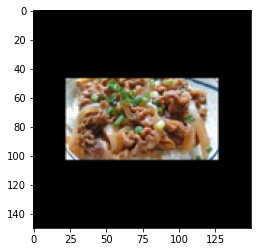

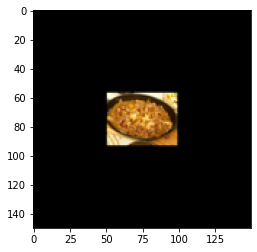

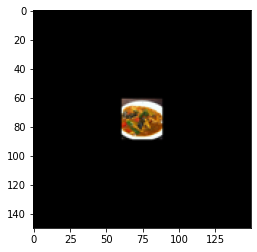

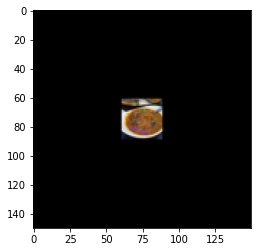

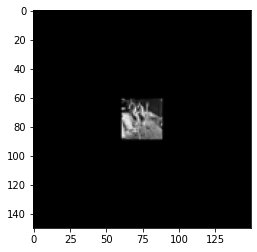

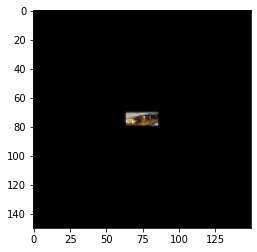

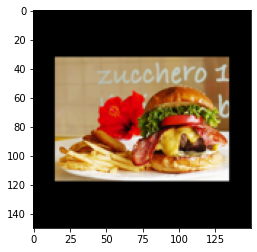

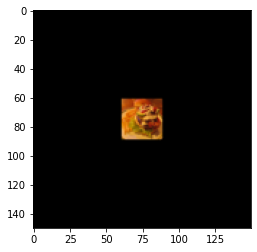

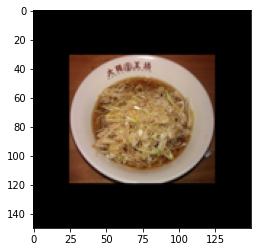

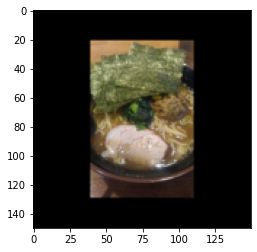

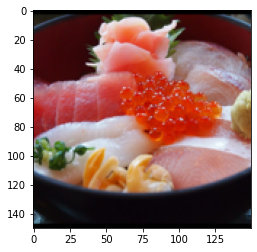

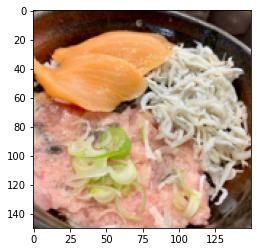

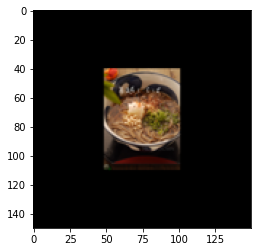

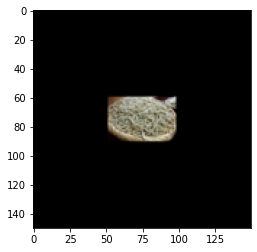

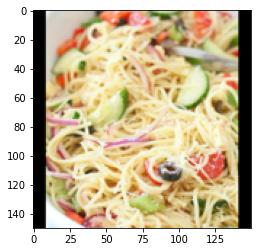

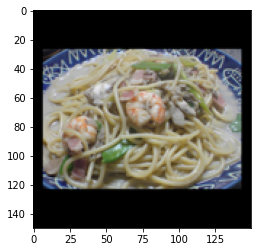

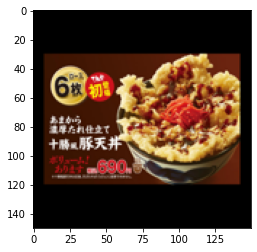

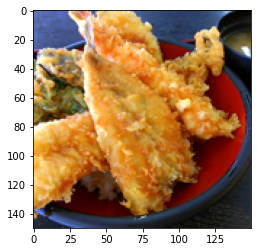

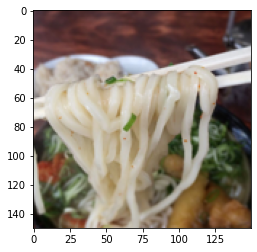

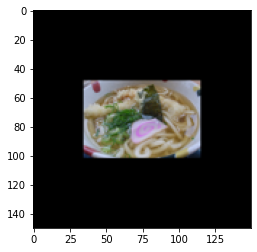

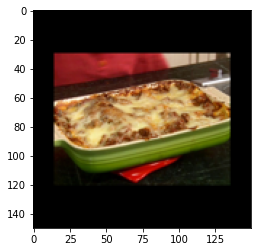

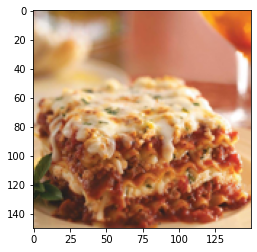

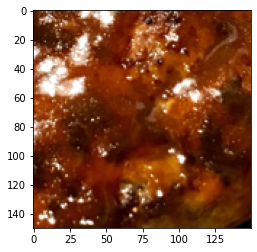

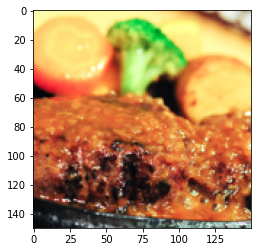

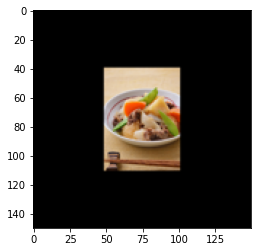

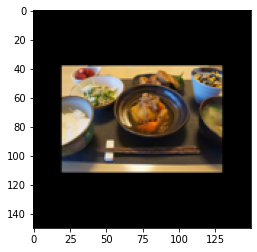

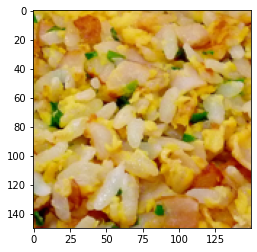

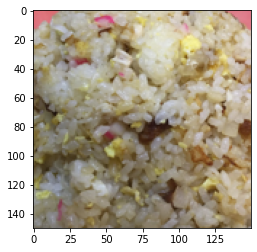

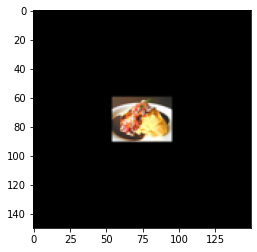

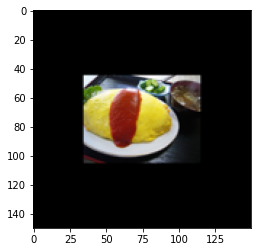

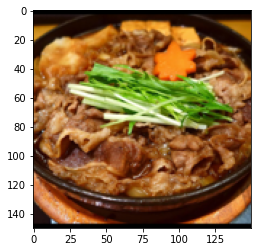

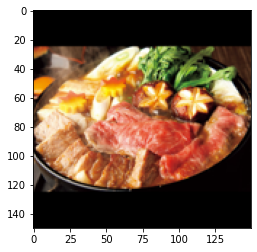

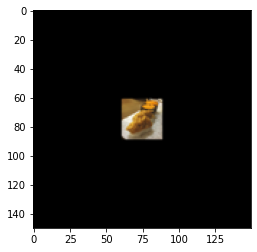

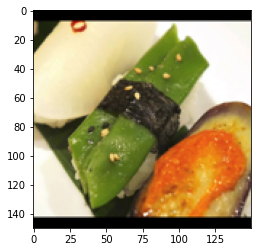

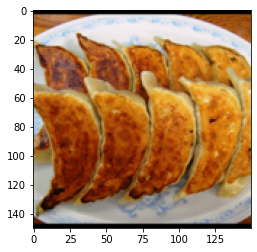

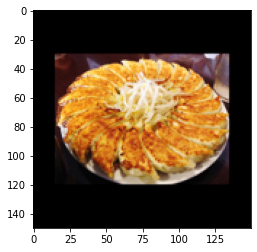

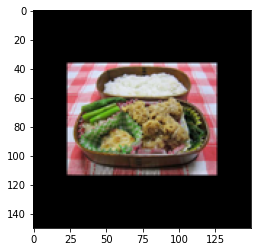

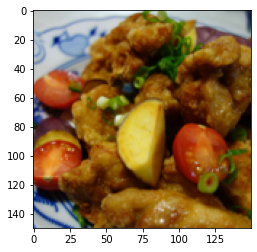

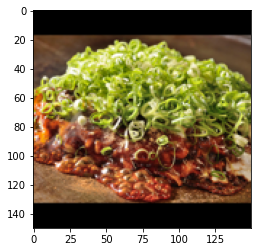

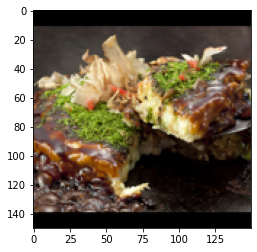

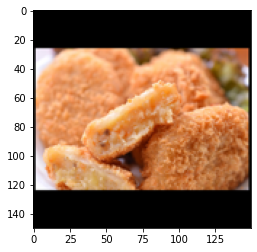

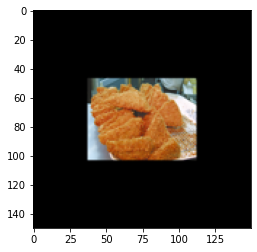

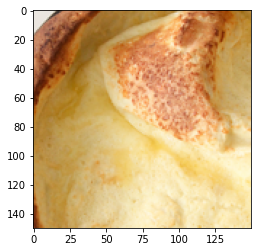

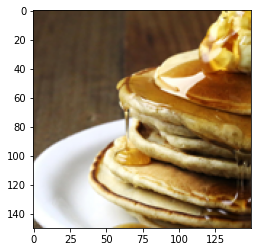

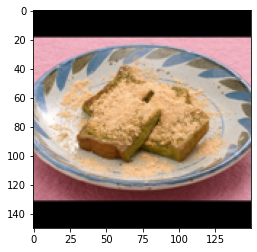

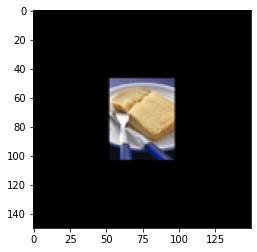

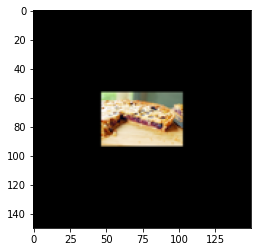

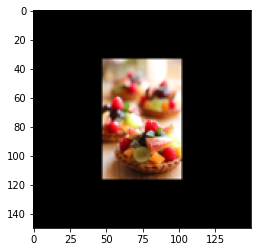

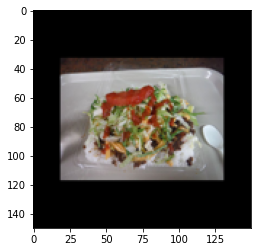

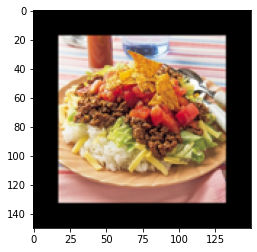

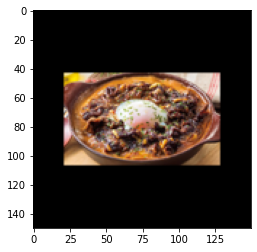

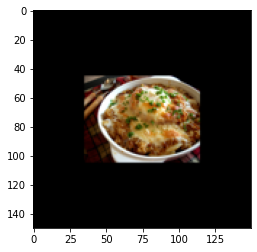

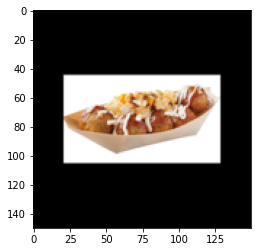

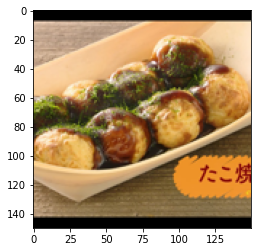

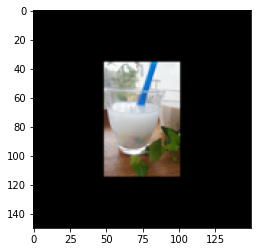

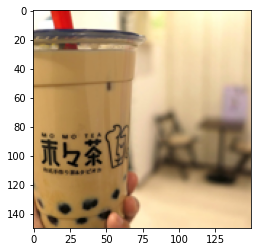

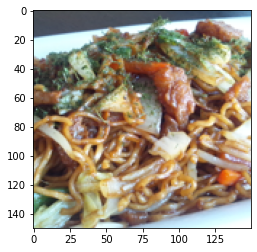

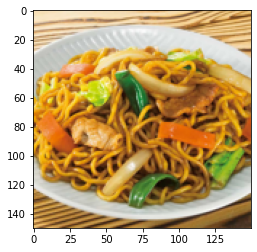

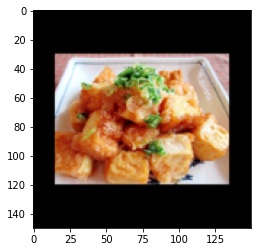

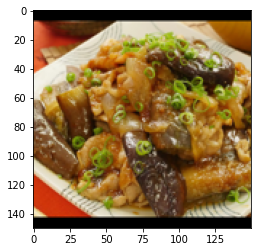

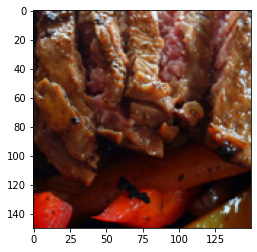

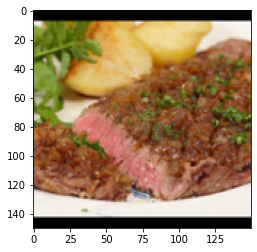

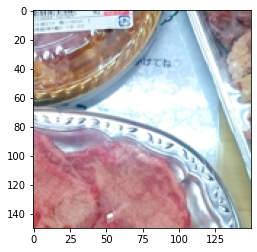

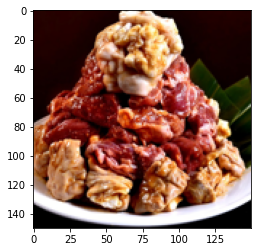

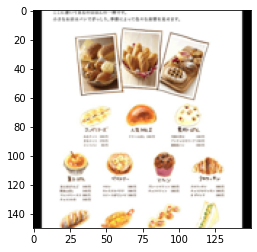

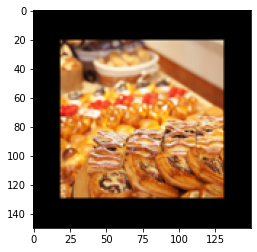

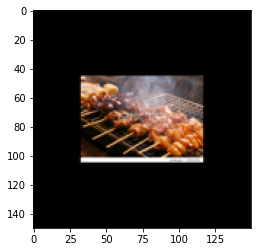

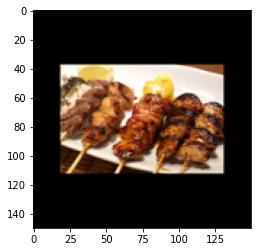

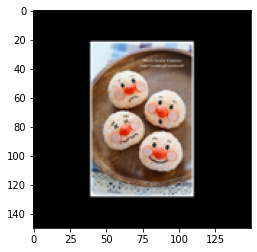

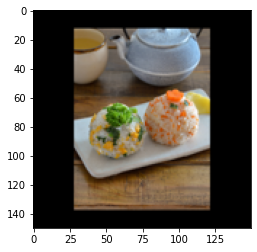

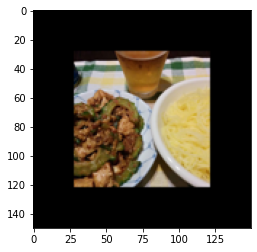

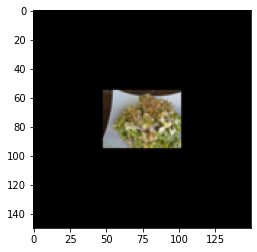

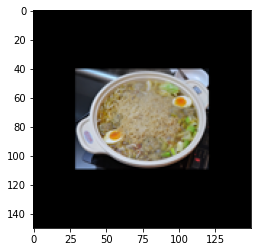

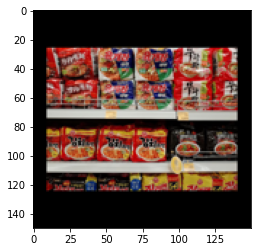

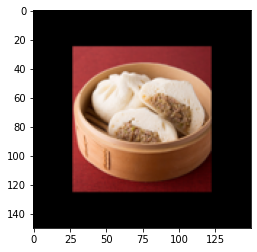

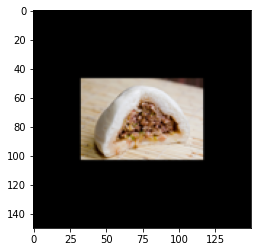

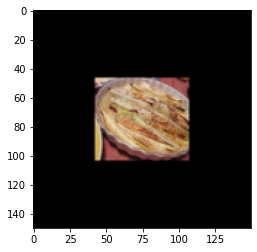

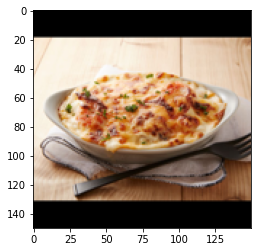

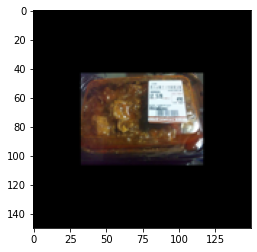

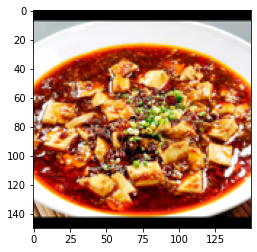

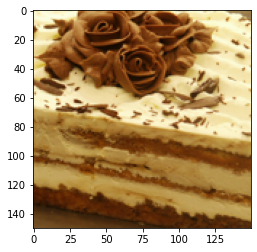

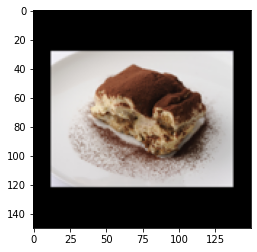

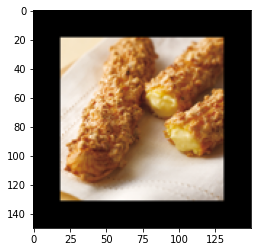

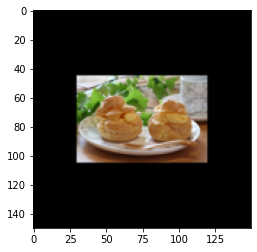

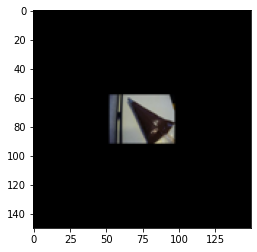

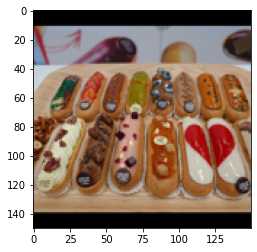

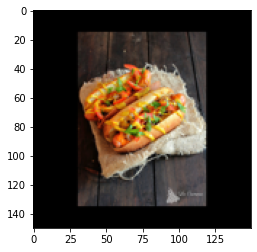

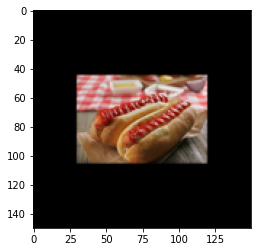

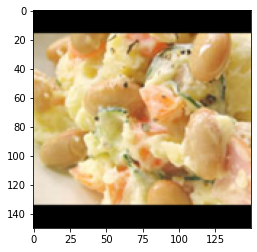

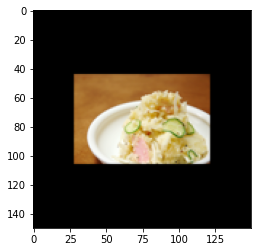

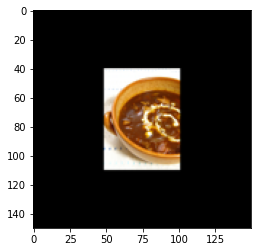

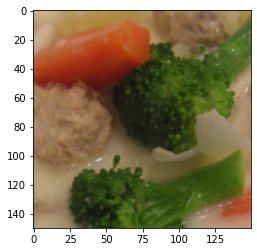

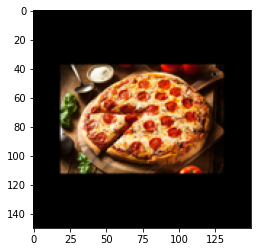

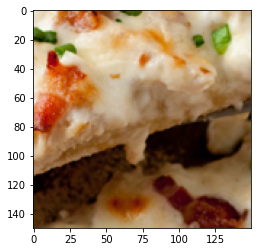

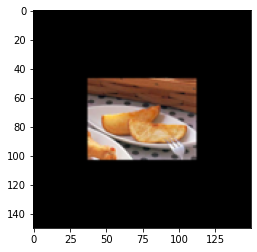

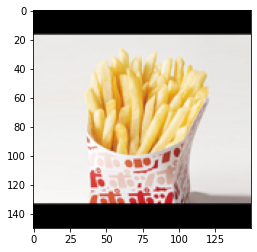

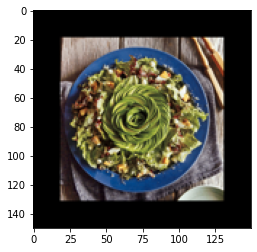

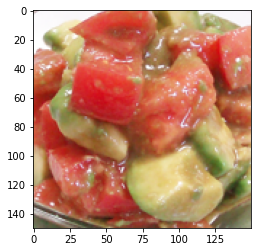

In [ ]:
for index, classlabel in enumerate(classes):
    photos_dir = './food/' + classlabel  
    files = glob.glob(photos_dir + '/*.jpg')
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert('RGB')
        # image = image.convert('RGB')の前にトリミングするとメモリオーバー、理由不明
        image = crop_center(image, 800, 800) # resizeする時にアスペクト比を固定させるため、800*800の部分をトリミング
        image = image.resize((image_size, image_size))
        data = np.asarray(image, dtype=np.float32) / 255.0  # 正規化 # dtype=np.float32でサイズ縮小、MemoryError解消のため # 2020/7/7
        data = np.array(data)
        process(data)
        X = []
        # 最後尾に追加する
        X.append(data)
        X = np.array(X)
        result = model.predict([X])[0]
        # 値の大きい方の番号(配列の添字)を返す
        predicted = result.argmax()
        percentage = int(result[predicted] * 100)
        print(classes[predicted], percentage)
        print()
        if i > 0:
          break